In [1]:
import os
import time
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt # 基础数据处理

from random import sample # 随机采样

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader # Pytorch
print(torch.__version__)

import torchvision
import torchvision.transforms as transforms

from tqdm import tqdm as tqdm


1.1.0


# Dataset & Dataloader & Preprocessing
For dataprocessing, the mean and std will be computed when init()

In [5]:
train_root = './train'
labels = os.listdir(train_root)


class DrawDataset(Dataset):
    def __init__(self, data_root = '',transform = None,anlysis = False):
        self.mean = 0.16443629118313927
        self.std = 0.3239202530511322
        self.transform = transform
        self.anlysis = False # only used when first computation
        self.label_mapper = {'airplane': 0, 'ant': 1, 'bear': 2, 'bird': 3, 'bridge': 4,
                        'bus'     : 5, 'calendar': 6, 'car': 7, 'chair': 8, 'dog': 9,
                        'dolphin' : 10, 'door': 11, 'flower': 12, 'fork': 13, 'truck': 14}
        self.IO_mapper = []
        for train_root in data_root:
            for x in self.label_mapper:
                print('loading class:',x,'in',train_root)
                temp_root = os.path.join(train_root,x)
                temp_list = os.listdir(temp_root)
                for img in temp_list:
                    full_str = os.path.join(temp_root,img)
                    self.IO_mapper.append([full_str , self.label_mapper[x]])
        print('Data loading finished,',len(self.IO_mapper),'totally')
        print('Data Cleaning Fire ON!!!')
        self.CleanIO_mapper = []
        for i in tqdm(range(0,len(self.IO_mapper))):
            figure = cv2.imread(self.IO_mapper[i][0],0)
            try:
                shape = figure.shape
            except:
#                 print('Oh, you can not really drawing~')
                continue
            else:
                if figure.shape != (28,28):
                    continue
                else:
                    self.CleanIO_mapper.append(self.IO_mapper[i])
#                     print('Oh, you can really drawing~')
        self.IO_mapper = self.CleanIO_mapper
        del self.CleanIO_mapper
        print('Data loading finished,',len(self.IO_mapper),'remaining')
        if anlysis:
            self.analysis()
    
    def __len__(self):
        return len(self.IO_mapper)
    
    def __getitem__(self,idx):
        image = cv2.imread(self.IO_mapper[idx][0],0)
        if self.transform is not None:
            image = self.transform(Image.fromarray(image))
        return image,self.IO_mapper[idx][1]
    
    def analysis(self):
        print('Data analysising……')
        self.mean = 0
        self.std = 0
        temp = []
        for i in tqdm(self):
            img = i[0].flatten() # 转为一维数组方便计算
            self.mean += np.sum(img)
        self.mean = self.mean / (len(self)*img.size)
        print('Mean:',self.mean)
        for i in self:
            img = i[0].flatten() # 转为一维数组方便计算
            self.std = self.std + np.sum((img - self.mean) ** 2)
        self.std = np.sqrt(self.std / (len(self)*img.size))
        print('Std:',self.std)


# Preprocessing
train_transform = transforms.Compose([
    transforms.RandomCrop(28,padding = 4), # 在周围补0后随机裁切，相当于平移这个图像
#     transforms.Resize(32),
    transforms.RandomHorizontalFlip(), # 一半的概率水平翻转
    transforms.RandomRotation((-15,15)), # 随机旋转
    transforms.ToTensor(),
    transforms.Normalize((0.16443629118313927, ),(0.3239202530511322, ))
])

# Dataset & Dataloader
Draws = DrawDataset(['./train','./extra_training_data/data'],transform = train_transform)
dl = DataLoader(Draws, batch_size = 4, shuffle = True, num_workers = 8)


 23%|██▎       | 2469/10804 [00:00<00:00, 24685.90it/s]

loading class: airplane in ./train
loading class: ant in ./train
loading class: bear in ./train
loading class: bird in ./train
loading class: bridge in ./train
loading class: bus in ./train
loading class: calendar in ./train
loading class: car in ./train
loading class: chair in ./train
loading class: dog in ./train
loading class: dolphin in ./train
loading class: door in ./train
loading class: flower in ./train
loading class: fork in ./train
loading class: truck in ./train
loading class: airplane in ./extra_training_data/data
loading class: ant in ./extra_training_data/data
loading class: bear in ./extra_training_data/data
loading class: bird in ./extra_training_data/data
loading class: bridge in ./extra_training_data/data
loading class: bus in ./extra_training_data/data
loading class: calendar in ./extra_training_data/data
loading class: car in ./extra_training_data/data
loading class: chair in ./extra_training_data/data
loading class: dog in ./extra_training_data/data
loading class: 

100%|██████████| 10804/10804 [00:00<00:00, 11162.76it/s]

Data loading finished, 10370 remaining


In [6]:
a = cv2.imread(Draws.IO_mapper[0][0],0).shape
print(a)

(28, 28)


# Show Images & Labels

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


chair bear airplane door 


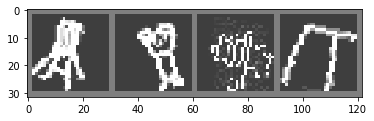

In [7]:
def imshow(img):
    img = img/2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))

dataiter = iter(dl)
images,labels = dataiter.next()

k = list(Draws.label_mapper.keys()) # [1,2,3,5,4]
v = list(Draws.label_mapper.values()) #[3,5,2,1,1]
imshow(torchvision.utils.make_grid(images))

labelshow = ''
for i in labels:
    labelshow += k[v.index(i)] + ' '
print(labelshow)

# Training

In [8]:
import torch.nn as nn

# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.0005
WEIGHT_DECAY = 0.001
BATCH_SIZE = 512
NUM_EPOCHS = 750

# Architecture
NUM_FEATURES = 28*28
NUM_CLASSES = 15

# Other
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
GRAYSCALE = True
print('We will implement this model on:',DEVICE,'!')

# for server-1
# Datasets
trainset = Draws

# DataLoader

trainloader = DataLoader(Draws, batch_size=BATCH_SIZE, shuffle = True, num_workers = 0)

classes = ['airplane', 'ant', 'bear', 'bird', 'bridge',
                        'bus', 'calendar', 'car', 'chair', 'dog',
                        'dolphin', 'door', 'flower', 'fork', 'truck']

# Checking datasets
for images, labels in trainloader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break


We will implement this model on: cuda !
Image batch dimensions: torch.Size([512, 1, 28, 28])
Image label dimensions: torch.Size([512])


In [15]:

def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1
    
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out




class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes, grayscale):
        self.inplanes = 64
        in_dim = 1
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        # because MNIST is already 1x1 here:
        # disable avg pooling
        #x = self.avgpool(x)
        
        x = x.view(x.size(0), -1)
        logits = self.fc(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas



def resnet34(num_classes):
    """Constructs a ResNet-34 model."""
    model = ResNet(block=BasicBlock, 
                   layers=[3, 4, 6, 3],
                   num_classes=NUM_CLASSES,
                   grayscale=GRAYSCALE)
    return model

In [9]:
torch.manual_seed(RANDOM_SEED)

model = resnet34(NUM_CLASSES)
model.to(DEVICE)
if(DEVICE == 'cuda'):
    model=torch.nn.DataParallel(model)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

In [13]:
import time
import torch.nn.functional as F
def compute_accuracy(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100
    

start_time = time.time()
for epoch in range(0, NUM_EPOCHS):
    
    model.train()
    for batch_idx, (features, targets) in enumerate(trainloader):
        
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)
            
        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 70:
            print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f' 
                   %(epoch+1, NUM_EPOCHS, batch_idx, 
                     len(trainloader), cost))

        

    model.eval()
    with torch.set_grad_enabled(False): # save memory during inference
        print('Epoch: %03d/%03d | Train: %.3f%%' % (
              epoch+1, NUM_EPOCHS, 
              compute_accuracy(model, trainloader, device=DEVICE)))
        
    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))


with torch.set_grad_enabled(False): # save memory during inference
    print('Test accuracy: %.2f%%' % (compute_accuracy(model, trainloader, device=DEVICE)))
    
print('Total Time: %.2f min' % ((time.time() - start_time)/60))



def save_model(the_model, PATH = 'final.pkl'):
    torch.save(the_model.module.state_dict(), PATH)


    
save_model(model)


RuntimeError: Given groups=1, weight of size 16 3 3 3, expected input[128, 1, 28, 28] to have 3 channels, but got 1 channels instead

In [17]:
def save_model(the_model, PATH = 'final.pkl'):
    torch.save(the_model.module.state_dict(), PATH)


    
save_model(model)

# Inference
## Load model

In [16]:
# model_loader



def load_model(PATH = 'final.pkl'):
    test_model = resnet34(NUM_CLASSES)
    test_model.load_state_dict(torch.load(PATH))
    return test_model


test_model = load_model()

torch.manual_seed(RANDOM_SEED)

test_model.to(DEVICE)
if(DEVICE == 'cuda'):
    test_model=torch.nn.DataParallel(test_model)

test_model.eval()
# optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)




DataParallel(
  (module): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_s

# TestDataSet & DataLoader

In [17]:
class TestDataset(Dataset):
    def __init__(self, data_root = '',transform = None):
        self.mean = 0.16443629118313927
        self.std = 0.3239202530511322
        self.transform = transform
        self.label_mapper = {'airplane': 0, 'ant': 1, 'bear': 2, 'bird': 3, 'bridge': 4,
                        'bus'     : 5, 'calendar': 6, 'car': 7, 'chair': 8, 'dog': 9,
                        'dolphin' : 10, 'door': 11, 'flower': 12, 'fork': 13, 'truck': 14}
        self.IO_mapper = []
        self.picids = []
        temp_list = os.listdir(data_root)
        for img in temp_list:
            self.picids.append(img.split('.')[0])
            full_str = os.path.join(data_root,img)
            self.IO_mapper.append(full_str)
        print('Data loading finished,',len(self.IO_mapper),'totally')
    
    def __len__(self):
        return len(self.IO_mapper)
    
    def __getitem__(self,idx):
        image = cv2.imread(self.IO_mapper[idx],0)
        picid = self.picids[idx]
        if self.transform is not None:
            image = self.transform(Image.fromarray(image))
        return picid, image

# Preprocessing
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.16443629118313927, ),(0.3239202530511322, ))
])
test_root = './released_test'
# Dataset & Dataloader
TestD = TestDataset(test_root, transform = test_transform)
Testdl = DataLoader(TestD, batch_size = 1024, shuffle = True, num_workers = 8)


Data loading finished, 45000 totally


# Do inference & writing csv file

In [18]:
import csv

import time
import torch.nn.functional as F
def compute_accuracy(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100
    

start_time = time.time()
pics = []
labels = []
with torch.set_grad_enabled(False): 
    for i, (picids,features) in tqdm(enumerate(Testdl)):
        features = features.to(DEVICE)
        picids = list(picids)
        logits, probas = test_model(features)
        _, predicted_labels = torch.max(probas, 1)
        predicted_labels = list(predicted_labels.cpu().numpy())
        pics += picids
        labels += predicted_labels
    print(len(pics),len(labels))
    
headers = ['id','categories']

with open('019033910029.csv','w')as f:
    f_csv = csv.writer(f)
    f_csv.writerow(headers)
    for i in tqdm(range(0,len(pics))):
        f_csv.writerow([int(pics[i]),int(labels[i])])


33it [00:03, 12.98it/s]


KeyboardInterrupt: 